# Main Diffusion Script
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import a_unet
except:
    !pip install a_unet


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler

from a_unet import TimeConditioningPlugin, ClassifierFreeGuidancePlugin
from a_unet.apex import XUNet, XBlock, ResnetItem as R, AttentionItem as A, CrossAttentionItem as C, ModulationItem as M, SkipCat

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

General

In [2]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_full_v7"
training_data_name: str = "training_full_raw"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [ ]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 2048
n_validation_samples: int = 50
batch_size: int = 8
tensor_dim: list = [batch_size, 1, 224, 416] #B, C, H, W

learning_rate: float = 5e-5
epochs: int = 100
restart_training: bool = True
checkpoint_freq: int = 5

### Data Loading

In [5]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-05-31 21:35:47,861 - INFO - Data loaded with shape: (7072, 128000)


### Setup

Model Creation

In [6]:
def UNet(dim: int, in_channels: int, channels: Sequence[int], factors: Sequence[int], items: Sequence[int], attentions: Sequence[int], cross_attentions: Sequence[int], attention_features: int, attention_heads: int, embedding_features: Optional[int] = None, skip_t: Callable = SkipCat, resnet_groups: int = 8, modulation_features: int = 1024, embedding_max_length: int = 0, use_classifier_free_guidance: bool = False, out_channels: Optional[int] = None):
    # Check lengths
    num_layers = len(channels)
    sequences = (channels, factors, items, attentions, cross_attentions)
    assert all(len(sequence) == num_layers for sequence in sequences)
    UNet = TimeConditioningPlugin(XUNet)
    if use_classifier_free_guidance:
        UNet = ClassifierFreeGuidancePlugin(UNet, embedding_max_length)

    return UNet(
        dim=dim,
        in_channels=in_channels,
        out_channels=out_channels,
        blocks=[
            XBlock(
                channels=channels,
                factor=factor,
                items=([R, M] + [A] * n_att + [C] * n_cross) * n_items,
            ) for channels, factor, n_items, n_att, n_cross in zip(*sequences)
        ],
        skip_t=skip_t,
        attention_features=attention_features,
        attention_heads=attention_heads,
        embedding_features=embedding_features,
        modulation_features=modulation_features,
        resnet_groups=resnet_groups
    )

In [ ]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=1,
    channels=[256, 512, 512, 512, 1024, 1024],
    factors=[1, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2],
    attentions=None,
    attention_features=None,
    attention_heads=None,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=2
).to(device)


In [6]:
u_net = UNet
u_net = DiffusionModel(
    net_t=u_net,
    dim=2,
    in_channels=1,
    channels=[128, 256, 512, 1024],
    factors=[2, 2, 2, 2],
    items=[2, 2, 2, 2],
    attentions=[0, 0, 0, 1],
    cross_attentions=[1, 1, 1, 1],
    attention_features=64,
    attention_heads=8,
    embedding_features=768,
    use_classifier_free_guidance=False,
    diffusion_t = VDiffusion,
    sampler_t = VSampler,
)

NameError: name 'UNet' is not defined

Model Loading

In [7]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-05-31 21:35:53,295 - INFO - Model diffusion_full_v7 created with ~115.8M Parameters


Initiate Trainer

In [ ]:
trainer = Trainer(u_net, optimizer, scheduler, device)

### Training

In [9]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=None,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

2025-05-31 21:35:58,289 - INFO - Training started on cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacty of 47.53 GiB of which 36.88 MiB is free. Process 1785049 has 47.49 GiB memory in use. Of the allocated memory 47.08 GiB is allocated by PyTorch, and 81.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Save Model Architecture

In [ ]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

/usr/local/lib/python3.11/dist-packages/einops/packing.py:148: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  lengths_of_composed_axes: List[int] = [-1 if -1 in p_shape else prod(p_shape) for p_shape in packed_shapes]
/usr/local/lib/python3.11/dist-packages/einops/packing.py:150: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_unknown_composed_axes = sum(int(x == -1) for x in lengths_of_composed_axes)


### Sample

2025-05-31 08:07:56,774 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-05-31 08:07:56,780 - LIGHT_DEBUG - Normalized to range: [-1,1]


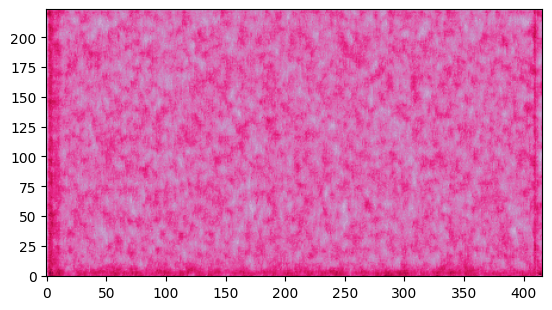

2025-05-31 08:07:56,975 - LIGHT_DEBUG - Normalized to range: [-1,1]


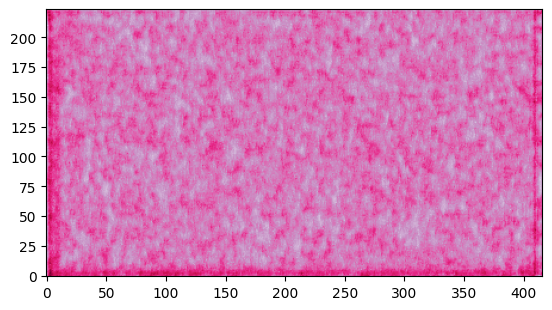

2025-05-31 08:07:57,133 - LIGHT_DEBUG - Normalized to range: [-1,1]


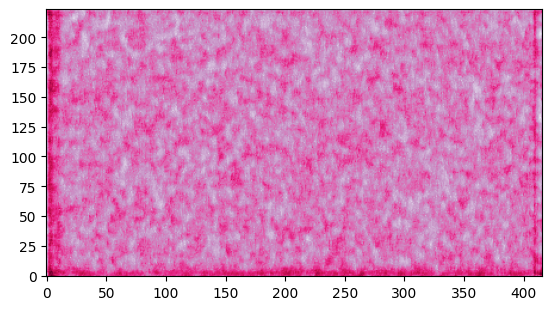

2025-05-31 08:07:57,286 - LIGHT_DEBUG - Normalized to range: [-1,1]


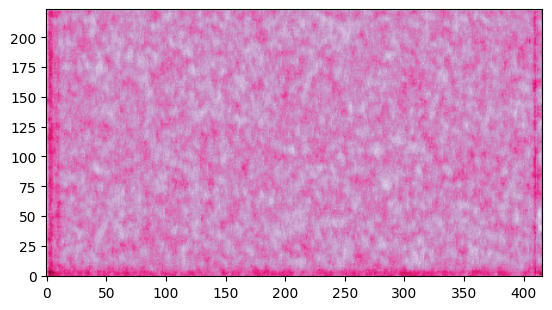

2025-05-31 08:07:57,441 - LIGHT_DEBUG - Normalized to range: [-1,1]


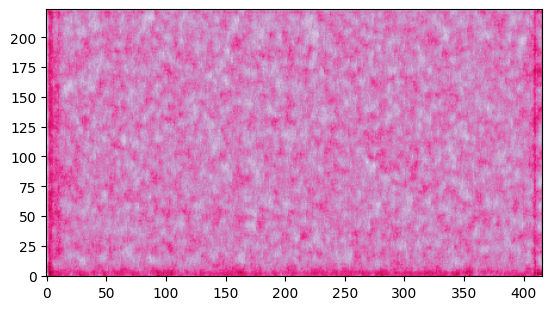

2025-05-31 08:07:57,591 - LIGHT_DEBUG - Normalized to range: [-1,1]


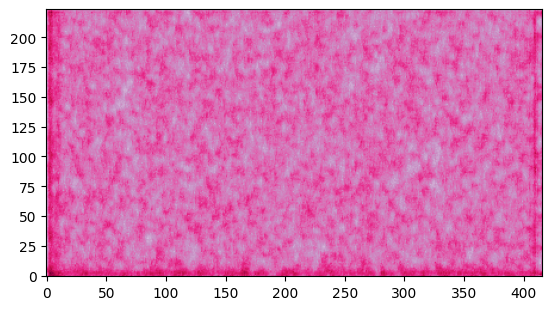

2025-05-31 08:07:57,744 - LIGHT_DEBUG - Normalized to range: [-1,1]


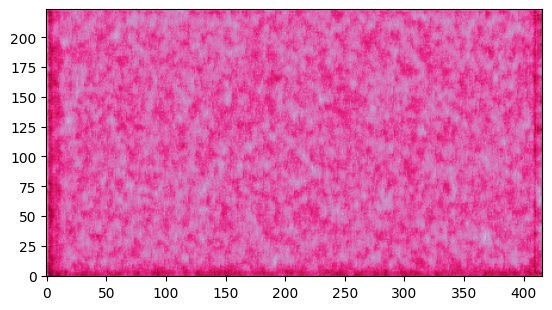

2025-05-31 08:07:57,895 - LIGHT_DEBUG - Normalized to range: [-1,1]


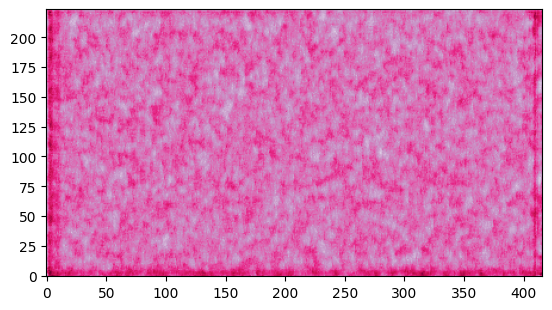

In [ ]:
samples = trainer.sample(8, tensor_dim, 50, True)

Save Samples

In [ ]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

Evaluate

In [ ]:
trainer.get_audio_metrics(samples, file)

NameError: name 'trainer' is not defined